# Background Reconstruction Template
Thomas Varnish (2020 UROP)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lmfit.models import Model
import time

from copy import copy

from magpie_data import DMFromArray, NeLMap, Interferogram

%matplotlib notebook

### Background Reconstruction from Shot Interferogram
Sometimes, the background interferogram's fringes are shifted/rotated compared to the shot, producing a strong gradient over the processed fringe shift map. Usually, you'll need to redo the shot. :(

This template will attempt to reconstruct the background phase map, given a masked shot phase map that contains "empty regions" (containing no plasma), which should be the same as the background. Using a Gaussian beam model for the phase, a 2D interpolation function fits the "empty" regions and then extrapolates to fill the whole image.

We begin by defininig the Gaussian beam model, some useful functions (for generating synthetic interferograms using cosine squared), and a Reconstruction class which wraps the lmfit routines.

In [3]:
def gaussian_beam(x, y, x0, y0, A, B, F, c, alpha, ravel_output=False):
    alpha = np.radians(alpha)
    xc, yc = x - x0, y - y0
    xr = xc * np.cos(alpha) + yc * np.sin(alpha)
    yr = xc * np.sin(alpha) - yc * np.cos(alpha)
    z = F * np.exp(-(np.power(xr/A, 2) + np.power(yr/B, 2))) + c
    if ravel_output is True:
        return z.ravel()
    else:
        return z

# Synthetic interferogram using cosine
def interferogram(z, traced_both=True):
    if traced_both:
        return np.cos(z * np.pi) ** 2
    else:
        return np.cos(z * np.pi * 2) ** 2

def mask_like(img, masked):
    mask = np.ma.masked_invalid(masked)
    masked_array = np.ma.masked_array(data=img, mask=np.ma.getmask(mask), fill_value=np.nan)
    return masked_array.filled(np.nan)
        
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
def nice_colorbar(ax, size="5%", pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)
    return cax

class Reconstruction:
    def __init__(self, function, initial_params, dont_vary=[]):
        self.function = function
        self.initial_params = initial_params
        
        self.model = Model(self.function, independent_vars=['x', 'y'], nan_policy="omit", kws={"ravel_output": True})
        
        self.params = self.model.make_params()
        
        for p in self.initial_params:
            if p == "alpha":
                self.params[p].set(self.initial_params[p], min=0, max=90, vary=("alpha" not in dont_vary))
            else:
                self.params[p].set(self.initial_params[p], vary=(p not in dont_vary))
            
    def _flattened_function(self, **kwargs):
        return self.function(**kwargs).ravel()        
    
    def fit(self, X, Y, shot, masked_shot, max_nfev=None, xtol=None, ftol=None):        
        start = time.perf_counter()
        
        fit_kws = {}
        if xtol is not None:  # Relative error desired in the approximate solution.
            fit_kws["xtol"] = xtol
        if ftol is not None:  # Relative error desired in the sum of squares.
            fit_kws["ftol"] = ftol
        
        # Run the fitting routine
        self.fit_result = self.model.fit(masked_shot.ravel(), self.params, 
                                         x=X.ravel(), y=Y.ravel(), 
                                         max_nfev=int(max_nfev),
                                         fit_kws=fit_kws)
        print(self.fit_result.fit_report())
        
        # Generate our full result from the best parameter values
        fitted = self.function(X, Y, **self.fit_result.best_values)
        masked_fit = mask_like(img=fitted, masked=shot)
        
        time_taken = time.perf_counter() - start
        
        return masked_fit, fitted, self.fit_result.best_values, time_taken

### 1. Load Masked Shot Interpolated Map
To reconstruct a background from our shot, we'll need to mask any regions which contain plasma, leaving only empty regions of the interferogram unmasked. You'll need to trace these regions of the shot, and label the fringes in Magic2. Interpolate the fringes to produce a phase map, and export this (not fringe shift) as a csv. We load in the full shot (to extract the outer mask), the masked shot (with an extra mask over where the plamsa is), and (if available) the background interpolated fringe data (the background, despite being rotated, will let us see the difference we've made with the reconstruction).

C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed


<IPython.core.display.Javascript object>


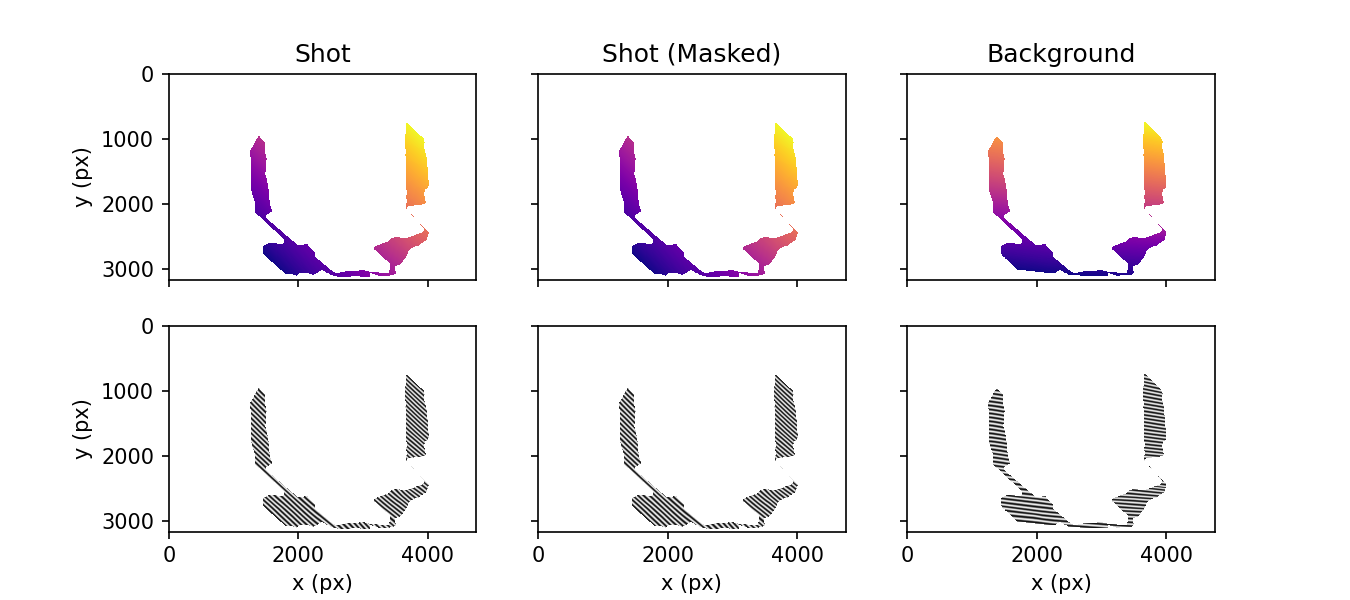

In [19]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed"

# Unmasked shot (for later fringe shift calculations, and to fetch the "proper" mask.
shot_fn = "s0327_18 532 nm side-on bk (rec) interpolated.csv"

# Masked shot (only empty regions remain unmasked)
shot_masked_fn = ""

# Background (so we can check our progress)
bk_fn = "s0327_18 532 nm side-on bk interpolated.csv"


### Load the phase maps and plot them to check they're the correct files.
shot = np.loadtxt(shot_fn, delimiter=",")
bk = np.loadtxt(bk_fn, delimiter=",")
# shot_masked = np.loadtxt(shot_masked_fn, delimiter=",")

# Plot it to check we've loaded the data correctly.
fig, ax = plt.subplots(2, 3, figsize=(9, 4), sharex=True, sharey=True)
ax[0, 0].imshow(shot, cmap="plasma")
ax[0, 1].imshow(shot_masked, cmap="plasma")
ax[0, 2].imshow(bk, cmap="plasma")

ax[1, 0].imshow(interferogram(shot), cmap="gray")
ax[1, 1].imshow(interferogram(shot_masked), cmap="gray")
ax[1, 2].imshow(interferogram(bk), cmap="gray")

ax[0, 0].set_title("Shot")
ax[0, 1].set_title("Shot (Masked)")
ax[0, 2].set_title("Background")

ax[0, 0].set_ylabel("y (px)")
ax[1, 0].set_ylabel("y (px)")
ax[1, 0].set_xlabel("x (px)")
ax[1, 1].set_xlabel("x (px)")
ax[1, 2].set_xlabel("x (px)")

# Form our coordinate arrays
x, y = np.arange(len(shot[0])), np.arange(len(shot))
X, Y = np.meshgrid(x, y)

### 2. Fit Gaussian Beam Fringe Pattern
Since one of the interferometer arms passes through optics (e.g. lenses, etc.) we assume a Gaussian model for the beam. We'll fit this model to the masked shot data, then produce a full-frame phase map using this fitted model. Fitting is done with the `lmfit` module, but wrapped inside the `Reconstruction` class to enable 2D fitting.

Set the initial conditions using the `initial` dictionary, and check this roughly matches the synthetic interferogram of the masked shot before continuing.

It may also be useful to come back to this cell and paste in the output from the model fitting routine for later reference. Sometimes you'll need to run the fitting routine a few times, to keep changing the initial conditions to match the output from the model to avoid having to run the fitting all over again.

<IPython.core.display.Javascript object>


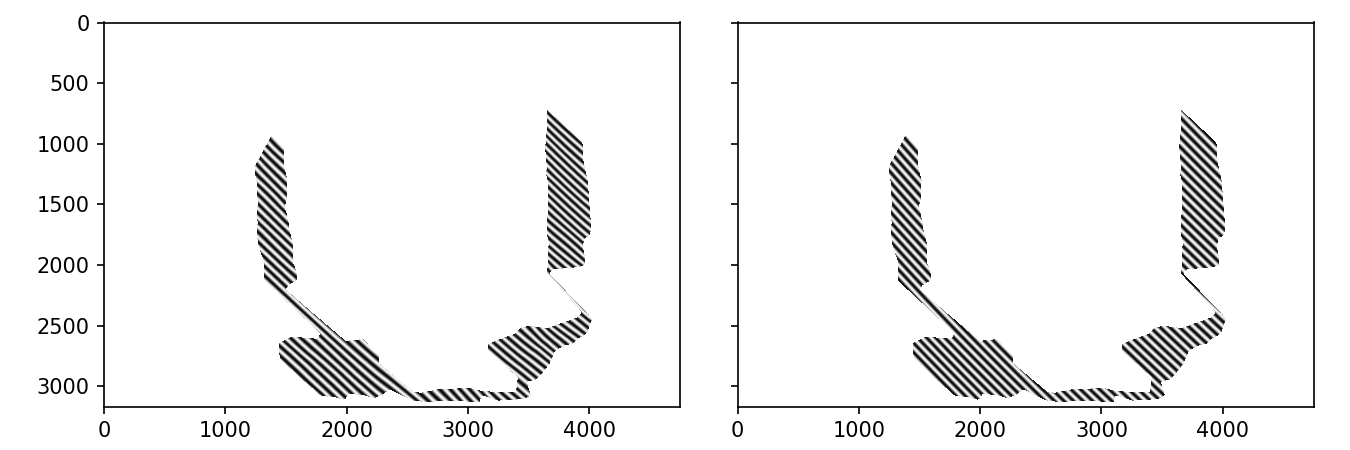

In [14]:
# initial = {"x0": 8e3, "y0": -4e3, "A": 1e6, "B": 1e6, "F": 2e6, "alpha": 0, "c": 0}  # Gaussian Beam
# initial = {"x0": 36392.6394, "y0": -33723.0261, "A": 1440357.66, "B": 1822678.43,
#            "F": 614083.521, "alpha": 60.2179971, "c": -613611.281}  # After 200 evals
# initial = {"x0": 37844.6087, "y0": -32837.7656, "A": 1362122.43, "B": 1828898.14, 
#            "F": 614084.747, "c": -613610.056, "alpha": 45.0735059}  # After 200 evals, then 30 with 1e-5 tolerances
initial = {"x0": 37844.6087, "y0": -32837.7656, "A": 1362122.43, "B": 1828898.14, 
           "F": 614084.747, "c": -613610.056, "alpha": 45.0735059}  # ... then 14 with 1e-6 tolerances

# === AFTER 200 function evals, then 30 with 1e-5 tolerances ===
# [[Model]]
#     Model(gaussian_beam)
# [[Fit Statistics]]
#     # fitting method   = leastsq
#     # function evals   = 14
#     # data points      = 1544424
#     # variables        = 7
#     chi-square         = 2107090.92
#     reduced chi-square = 1.36432771
#     Akaike info crit   = 479800.525
#     Bayesian info crit = 479886.276
# [[Variables]]
#     x0:     37844.6087 +/- 577.450501 (1.53%) (init = 37844.61)
#     y0:    -32837.7656 +/- 572.090433 (1.74%) (init = -32837.77)
#     A:      1362122.43 +/- 114299.081 (8.39%) (init = 1362122)
#     B:      1828898.14 +/- 154042.718 (8.42%) (init = 1828898)
#     F:      614084.747 +/- 102938.443 (16.76%) (init = 614084.7)
#     c:     -613610.056 +/- 102938.517 (16.78%) (init = -613610.1)
#     alpha:  45.0735059 +/- 0.02173849 (0.05%) (init = 45.07351)
# [[Correlations]] (unreported correlations are < 0.100)
#     C(F, c)     = -1.000
#     C(x0, y0)   = -1.000
#     C(A, F)     =  0.999
#     C(A, c)     = -0.999
#     C(A, B)     =  0.998
#     C(B, F)     =  0.995
#     C(B, c)     = -0.995
#     C(A, alpha) = -0.493
#     C(F, alpha) = -0.492
#     C(c, alpha) =  0.492
#     C(B, alpha) = -0.491


# Render a "guess" so we can refine (roughly) our initial parameters
z = gaussian_beam(X, Y, **initial)

z = mask_like(z, shot)

fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
ax[0].imshow(interferogram(shot_masked), cmap="gray")
ax[0].set_title("Shot (Masked)")
ax[1].imshow(interferogram(z), cmap="gray")
ax[1].set_title("Initial Guess")
fig.tight_layout()

#### Now we do the fitting!
Make sure to change `max_nfev` (maximum number of function evaluations), `xtol` (tolerance for termination in the independent variables), and `ftol` () if the routine is taking a long time.

One method I suggest: set `xtol`and `ftol` to `None` (i.e. their default in `lmfit`). Then, limit `max_nfev` to something small to guage how long each iteration takes to run. Once you know the time for one evaluation, set `max_nfev` to a reasonable "time" duration. After this, you may need to adjust `xtol` and `ftol` to narrow in on the best result. Keep checking the reduced chi-square value in the Model's Fit Statistics; it should be close to zero. Your results may vary!

In [17]:
rec = Reconstruction(gaussian_beam, initial)
fit_result, unmasked_fit, best_values, time_taken = rec.fit(X, Y, shot, shot_masked, max_nfev=1000, xtol=5e-6, ftol=5e-6)

time_sec = np.round(time_taken)
time_min = np.round(time_taken / 60.0, 1)

print(f"\nTime taken: {str(time_sec)} sec. ({str(time_min)} min.)")

# Save this to a (human-readable) file for safekeeping!
with open("best_parameters.txt", "w") as f:
    f.write("Shot: " + shot_fn + "\n\n")
    f.write(rec.fit_result.fit_report())

[[Model]]
    Model(gaussian_beam)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 1544424
    # variables        = 7
    chi-square         = 2107090.92
    reduced chi-square = 1.36432771
    Akaike info crit   = 479800.525
    Bayesian info crit = 479886.276
[[Variables]]
    x0:     37844.6087 +/- 577.450501 (1.53%) (init = 37844.61)
    y0:    -32837.7656 +/- 572.090433 (1.74%) (init = -32837.77)
    A:      1362122.43 +/- 114299.081 (8.39%) (init = 1362122)
    B:      1828898.14 +/- 154042.718 (8.42%) (init = 1828898)
    F:      614084.747 +/- 102938.443 (16.76%) (init = 614084.7)
    c:     -613610.056 +/- 102938.517 (16.78%) (init = -613610.1)
    alpha:  45.0735059 +/- 0.02173849 (0.05%) (init = 45.07351)
[[Correlations]] (unreported correlations are < 0.100)
    C(F, c)     = -1.000
    C(x0, y0)   = -1.000
    C(A, F)     =  0.999
    C(A, c)     = -0.999
    C(A, B)     =  0.998
    C(B, F)     =  0.995
    C(B, c) 

**Once the fitting routine has been run, check your results with the following plot:**

<IPython.core.display.Javascript object>


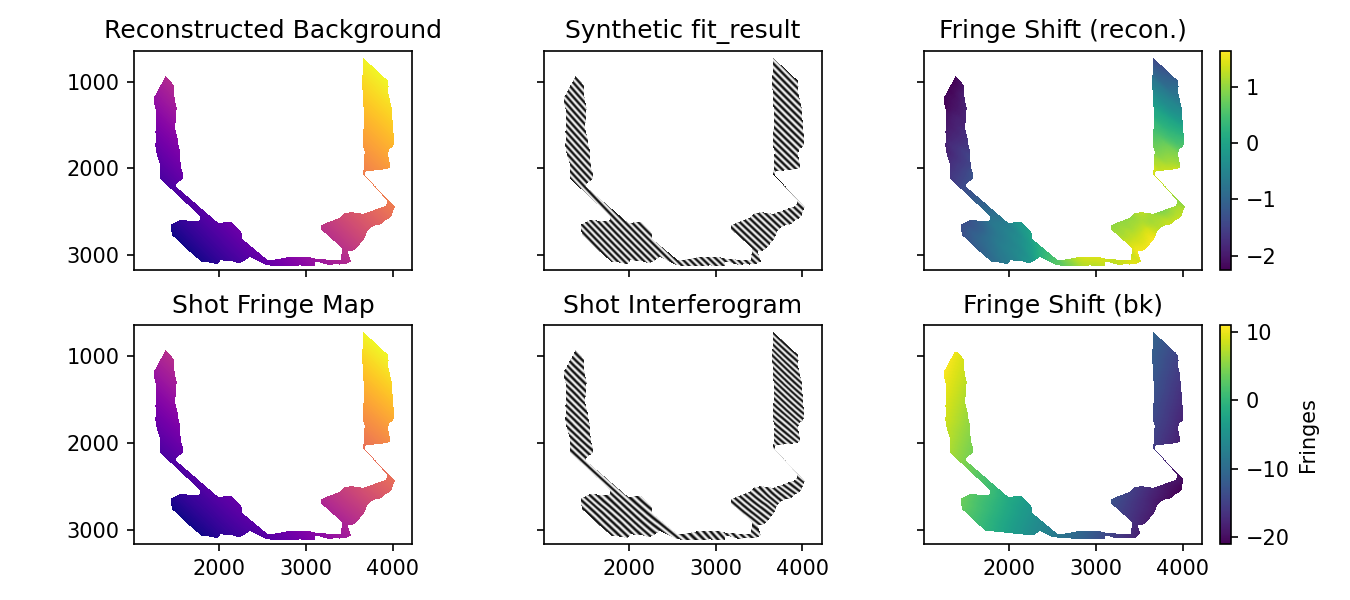

In [23]:
fringe_shift_reconstructed = fit_result - shot
fringe_shift_bk = bk - shot

# Let's have a quick look at the output to make sure it looks sensible!
fig, ax = plt.subplots(2, 3, figsize=(9, 4), sharex=True, sharey=True)
ax[0, 0].imshow(fit_result, cmap="plasma")
ax[0, 0].set_title("Reconstructed Background")
ax[0, 1].imshow(interferogram(fit_result), cmap="gray")
ax[0, 1].set_title("Synthetic fit_result")
shot_diff = ax[0, 2].imshow(fringe_shift_reconstructed)
fig.colorbar(shot_diff, ax=ax[0, 2])
ax[0, 2].set_title("Fringe Shift (recon.)")

ax[1, 0].imshow(shot, cmap="plasma")
ax[1, 0].set_title("Shot Fringe Map")
ax[1, 1].imshow(interferogram(shot), cmap="gray")
ax[1, 1].set_title("Shot Interferogram")
bk_diff = ax[1, 2].imshow(fringe_shift_bk)
fig.colorbar(bk_diff, ax=ax[1, 2], label="Fringes")
ax[1, 2].set_title("Fringe Shift (bk)")

fig.tight_layout()

### 3. Save the reconstructed background data
When you're happy with the fit, we can save the unmasked, full-frame, reconstructed background phase map. Choose a good location and filename, and run the following cell.

In [24]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed"

np.savetxt("s0327_18 532 nm side on (reconstructed bk).csv", unmasked_fit, delimiter=",")

C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed


### 4. Calculate Fringe Shift
Now that we've reconstructed the background, it's time to check our new fringe shift result. If the fitting has gone well, you should be left with a new fringe shift map with little-to-no gradient.

Begin by loading in the full shot and full background interpolated phase maps.

In [28]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed"

full_shot = np.loadtxt("s0327_18 532 nm side-on shot (full) interpolated.csv", delimiter=",")
full_bk = np.loadtxt("s0327_18 532 nm side-on bk (full) interpolated.csv", delimiter=",")

C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed


Now we calculate the fringe shifts for both the background and the reconstructed background. You may need to swap the order of the subtraction to "invert" the fringe shift map (like in Magic2).

In [29]:
fringe_shift = full_shot - full_bk
fringe_shift_rec = unmasked_fit - full_shot  # Inverse

Now plot the result!

<IPython.core.display.Javascript object>


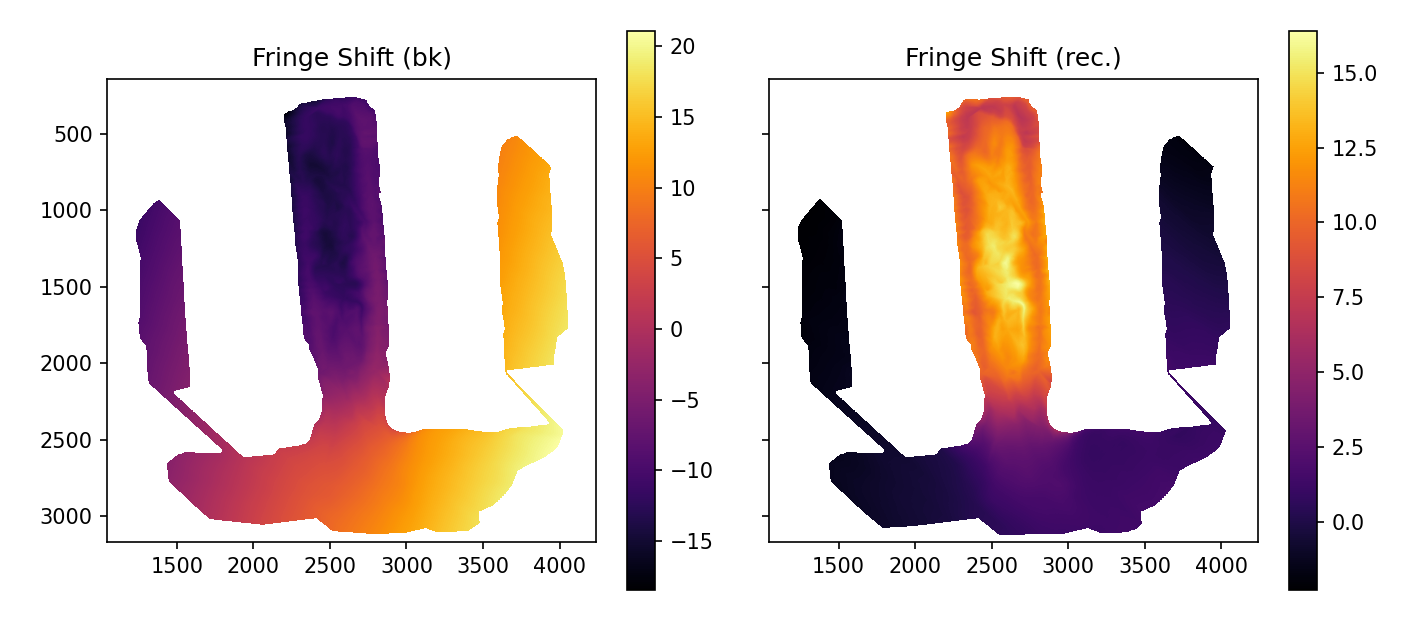

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

fs = ax[0].imshow(fringe_shift, cmap="inferno")
fig.colorbar(fs, ax=ax[0])
ax[0].set_title("Fringe Shift (bk)")

fs_rec = ax[1].imshow(fringe_shift_rec, cmap="inferno")
fig.colorbar(fs_rec, ax=ax[1])
ax[1].set_title("Fringe Shift (rec.)")

fig.tight_layout()

### 5. Save the (reconstructed) fringe shift data
Once you're happy with the fit and resulting fringe shift map, go ahead and save the fringe shift data as a csv so we can use the result in other notebooks.

In [32]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed"

np.savetxt("s0327_18 532 nm side-on bk (full) fringe shift (reconstructed).csv", fringe_shift_rec, delimiter=",")

C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed


### 6. Check lineouts (for gradients, etc)
Here we can check for any gradients on the fringe shift map. It's often easier to find them on lineouts than visually in a colour map. 

This section largely depends on how you need to process the data. You may need to set an origin, set a rotation, crop the image, etc. Below are some examples provided, but you'll usually need to re-write these last sections yourself.

In [ ]:
%cd "C:\Users\Thomas\Files\Magpie\analysis\complex_bk_reconstruction_tests\reconstructed"

flip_lr = False
rot = 0  # Unknow, and largely irrelevant?
scale = 1  # Again, unknown
    
s0327_18_532 = NeLMap('s0327_18 532 nm side-on (full) fringe shift.csv', scale=scale, rot_angle=rot, multiply_by=np.pi, flip_lr=flip_lr)
s0327_18_532_rec = NeLMap('s0327_18 532 nm side-on bk (full) fringe shift (reconstructed).csv', scale=scale, rot_angle=rot, multiply_by=np.pi, flip_lr=flip_lr)

In [36]:
# o_532 = (0, 0)  # Arb.
# e = [0, 6, -7, 7]
# e = [0, s0327_18_532.data.shape[0], 0, s0327_18_532.data.shape[1]]

# s0327_18_532.set_origin(origin=o_532, extent=e)
# s0327_18_532_rec.set_origin(origin=o_532, extent=e)

<IPython.core.display.Javascript object>


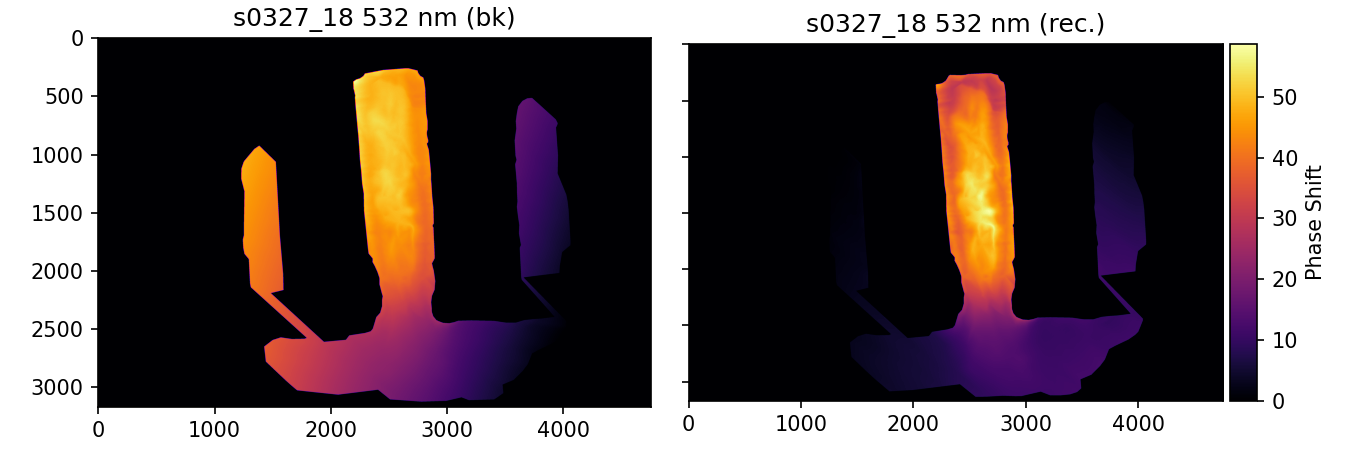

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

img = s0327_18_532.plot_data_px(ax=ax[0])
img_r = s0327_18_532_rec.plot_data_px(ax=ax[1])

ax[0].set_title("s0327_18 532 nm (bk)")
ax[1].set_title("s0327_18 532 nm (rec.)")
# ax[0].set_xlabel("x (px)")
# ax[1].set_xlabel("x (px)")
# ax[0].set_ylabel("z (px)")

cax = nice_colorbar(ax[1], size="5%", pad=0.05)
fig.colorbar(img_r, cax=cax, label="Phase Shift")

fig.tight_layout()

<IPython.core.display.Javascript object>


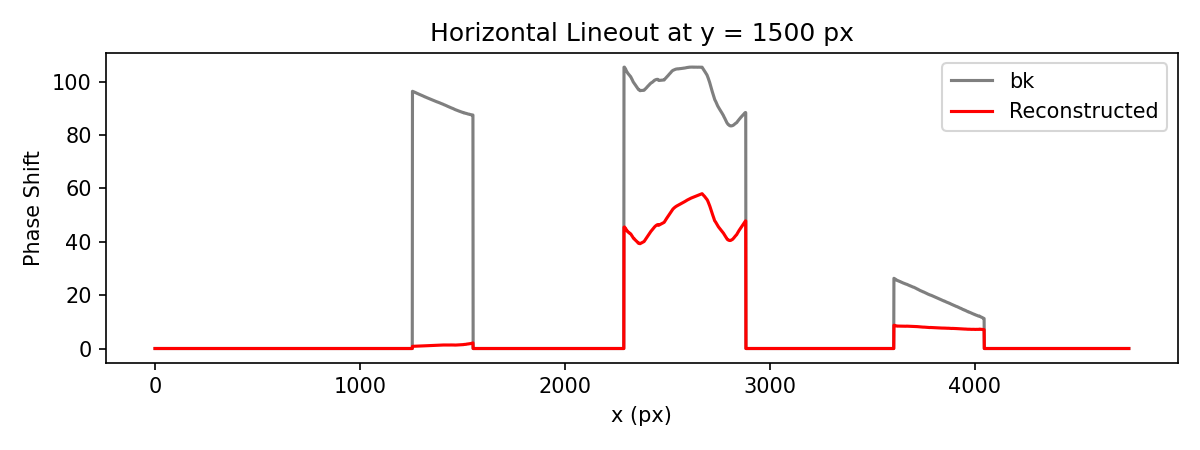

In [50]:
xx = len(s0327_18_532.data[0])
bk_name = "bk"

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
zz = 1500

ax.plot(s0327_18_532.data[zz, :], color="black", alpha=0.5, label=bk_name)
ax.plot(s0327_18_532_rec.data[zz, :], color="red", label="Reconstructed")
        
ax.set_ylabel("Phase Shift")
ax.legend()
ax.set_title("Horizontal Lineout at y = 1500 px")
ax.set_xlabel("x (px)")

fig.tight_layout()